# Example 2

> This example will validate the code of the TEF package by comparing the results with the analytical example of Burchard et al. (2019) and Lorenz et al. (2019).

In [1]:
from pyTEF.tef_core import *
import numpy as np
import pylab as plt
import xarray as xr
import time

## Input

We start by defining the necessary parameters:

Cross section: $ A = 10000 m^2$

Tidal period: $ T = 12 h * 3600 \frac{s}{h}$

Tidal frequency: $\omega = 2 * \pi / T$ 

Residual velocity: $ u_r = -0.1 $

Tidal velocity amplitude: $ u_a = 1.$

Residual salinity: $s_r = 20. g/kg$ 

amplitude of salinity changes within one tidal cycle: $s_a = 10. g/kg$ 

phase lag between velocity and salt: $\phi = \arccos(-2\frac{u_r s_r}{u_a s_a}) $

N = 10000


In [2]:
A = 10000. 
T = 12*3600
omega = 2*np.pi/T #
u_r = -0.1 
u_a = 1.
s_r = 20. 
s_a = 10. 
phi = -np.arccos(-2*(u_r*s_r)/(u_a*s_a)) 
N = 10000

## Analytical functions

In [3]:
def u_vel_analytical(t):
    return u_r+u_a*np.cos(2*np.pi*t)
    
def s_analytical(t):
    return s_r + s_a*np.cos(2*np.pi*t+phi)

Define analytical solution according to Appendix of Lorenz et al. (2019)

In [4]:
def Q_analytical(S):
    t_1 = -1/omega*(np.arccos((S-s_r)/s_a)+phi)
    t_2 = 1/omega*(np.arccos((S-s_r)/s_a)-phi)
    Q = A/T*(u_r*t_2+u_a/omega*np.sin(omega*t_2)-u_r*t_1-u_a/omega*np.sin(omega*t_1))
    return(Q)
    
def Qs_analytical(S):
    t_1 = -1/omega*(np.arccos((S-s_r)/s_a)+phi)
    t_2 = 1/omega*(np.arccos((S-s_r)/s_a)-phi)
    Qs = A/T*(u_r*s_r*(t_2-t_1)+u_a*s_r/omega*(np.sin(omega*t_2)-np.sin(omega*t_1)) + u_r*s_a/omega*(np.sin(omega*t_2 + phi)-np.sin(omega*t_1+phi))\
    +u_a*s_a/2*np.cos(phi)*(t_2-t_1 + 1/omega *np.sin(omega*t_2)*np.cos(omega*t_2) - 1/omega *np.sin(omega*t_1)*np.cos(omega*t_1))\
    -u_a*s_a*np.sin(phi)/2/omega*(np.sin(omega*t_2)**2 - np.sin(omega*t_1)**2))
    return(Qs)    
    
def q_analytical(S):
    q=-A/(T*omega)*1/(np.sqrt(s_a**2-(S-s_r)**2))*(-2*u_r-u_a*np.cos(np.arccos((S-s_r)/s_a)-phi)-u_a*np.cos(np.arccos((S-s_r)/s_a)+phi))
    return(q)

### Discretizing the analytical functions

Create the discrete values for time, volume transport, salt, and salt transport for N discrete value

In [5]:
t = np.float64(np.arange(0, 1, 1/N))                  # time array (0 to 1 , so relative to one Tidal cycle T)
volume_transport = A*np.float64(u_vel_analytical(t))    # volume transport
salt = np.float64(s_analytical(t))                    # salt / salinity
salt_transport = A*np.float64(u_vel_analytical(t)*salt) # salt transport

data = xr.Dataset({"salt": (["time"], salt),                 
                   "volume_transport": (["time"], volume_transport),
                   "salt_transport": (["time"], salt_transport)},
                    coords={"time": (["time"], t)})

### Plot analytical functions

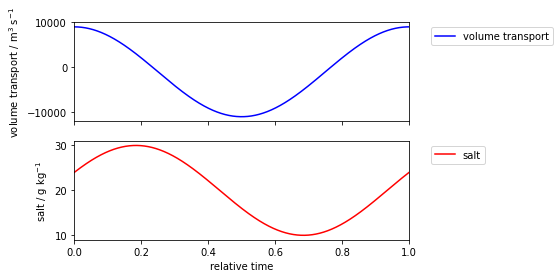

In [6]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(t, volume_transport, color='blue', label='volume transport')
ax[0].legend(loc='upper left', bbox_to_anchor=(1.05, 1))
ax[0].set_ylabel('volume transport / m$^3$ s$^{-1}$')
ax[1].plot(t, salt, color='red', label='salt')
ax[1].set_ylabel('salt / g kg$^{-1}$')
ax[1].set_xlabel('relative time')
ax[1].set_xlim(0,1)
ax[1].legend(loc='upper left',bbox_to_anchor=(1.05, 1))
plt.show()

## Setup TEF routine

Perform TEF analysis using the `pyTEF` package.

In [7]:
tef = TEF_object(ds=data)
tef.set_up() # validate dimensions

Created dummy dimension for longitude
Created dummy dimension for latitude
Created dummy dimension for depth


Sort into salinity classes. From the paper and the data we know what s_min and s_max should be:


In [8]:
s_min  = 10.0
s_max  = 31.0
N_bins = 1024

start = time.time()
out_volume = tef.sort_1dim(tef.ds.salt,
                    transport = tef.ds.volume_transport,
                    N = N_bins,
                    minmaxrange=(s_min, s_max))
end = time.time()
print("That took {:.2f} seconds".format(end-start))
start = time.time()
out_salt = tef.sort_1dim(tef.ds.salt,
                    transport = tef.ds.salt_transport,
                    N = N_bins,
                    minmaxrange=(s_min, s_max))
end = time.time()
print("That took {:.2f} seconds".format(end-start))

Constructing var_q and var_Q

Dimensions should be equal to 3, but they are not.



100%|██████████| 1024/1024 [00:01<00:00, 572.42it/s]



Dimensions should be equal to 3, but they are not.

That took 1.93 seconds
Constructing var_q and var_Q

Dimensions should be equal to 3, but they are not.



100%|██████████| 1024/1024 [00:02<00:00, 461.81it/s]



Dimensions should be equal to 3, but they are not.

That took 2.33 seconds


Do temporal mean and compute the numerical bulk values.

In [9]:
q_mean = out_volume.q.mean('time')
Q_mean = out_volume.Q.mean('time')
Qs_mean = out_salt.Q.mean('time')

bulk_values_volume = tef.calc_bulk_values(out_volume.var_Q, Q_mean)
bulk_values_salt = tef.calc_bulk_values(out_salt.var_Q, Qs_mean)

Q_in_num = bulk_values_volume.Qin[0].values
Q_out_num = bulk_values_volume.Qout[0].values

Qs_in_num = bulk_values_salt.Qin[0].values
Qs_out_num = bulk_values_salt.Qout[0].values

s_in_num  = Qs_in_num / Q_in_num
s_out_num = Qs_out_num / Q_out_num

100%|██████████| 2/2 [00:00<00:00, 1392.07it/s]


## Compare to analytical solution

In [10]:
s_div=np.float64(-s_a*u_r/u_a/np.cos(phi)+s_r) #analytical dividing salinity
Q_in_ana  = Q_analytical(s_div)
Q_out_ana = Q_analytical(10.) - Q_in_ana

Qs_in_ana = Qs_analytical(s_div)
Qs_out_ana= Qs_analytical(10.) - Qs_in_ana

s_in_ana  = Qs_in_ana / Q_in_ana
s_out_ana = Qs_out_ana / Q_out_ana

print('Q_in: \nanalytical      {},\nnumerical       {},\nrelative error  {:.2f}%'.format(Q_in_ana,Q_in_num,np.abs((Q_in_num-Q_in_ana)/Q_in_ana)*100))
print('Q_out: \nanalytical      {},\nnumerical       {},\nrelative error  {:.3f}%'.format(Q_out_ana,Q_out_num,np.abs((Q_out_num-Q_out_ana)/Q_out_ana)*100))
print('s_in: \nanalytical      {}, \nnumerical       {},    \nrelative error  {:.3f}%'.format(s_in_ana,s_in_num,np.abs((s_in_num-s_in_ana)/s_in_ana)*100))
print('s_out: \nanalytical      {}, \nnumerical       {}, \nrelative error  {:.3f}%'.format(s_out_ana,s_out_num,np.abs((s_out_num-s_out_ana)/s_out_ana)*100))

Q_in: 
analytical      813.2395113781663,
numerical       813.329298933383,
relative error  0.01%
Q_out: 
analytical      -1813.2395113781665,
numerical       -1813.3292989333866,
relative error  0.005%
s_in: 
analytical      28.423565664110257, 
numerical       28.422911964641628,    
relative error  0.002%
s_out: 
analytical      12.747994132742775, 
numerical       12.748477110828695, 
relative error  0.004%


**Note**: If you are performing more than one TEF analysis at once, it might be convenient to rename the variable `var_Q ` and `var_q`.

In [11]:
out_volume = out_volume.rename({"var_Q": "salt_Q",
                                "var_q": "salt_q"})

### Plot comparison of analytical and TEF numerical solution

/home/flo/miniconda3/envs/gpu/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)
/home/flo/miniconda3/envs/gpu/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/flo/miniconda3/envs/gpu/lib/python3.8/site-packages/xarray/core/computation.py:739: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


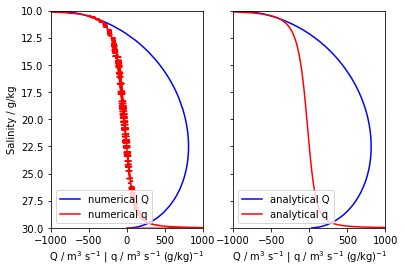

In [12]:
fig,ax=plt.subplots(1,2,sharex=True,sharey=True)
ax[0].plot(Q_mean,out_volume.salt_Q,color='blue',label='numerical Q')
ax[0].plot(q_mean,out_volume.salt_q,color='red',label='numerical q')
ax[0].legend(loc='lower left')
ax[0].set_ylabel('Salinity / g/kg')
ax[0].set_xlabel('Q / m$^3$ s$^{-1}$ | q / m$^3$ s$^{-1}$ (g/kg)$^{-1}$')
ax[1].plot(Q_analytical(out_volume.salt_Q),out_volume.salt_Q,color='blue',label='analytical Q')
ax[1].plot(q_analytical(out_volume.salt_q),out_volume.salt_q,color='red',label='analytical q')
ax[1].legend(loc='lower left')
ax[1].set_xlim(-1000,1000)
ax[1].set_ylim(30,10)
ax[1].set_xlabel('Q / m$^3$ s$^{-1}$ | q / m$^3$ s$^{-1}$ (g/kg)$^{-1}$')
plt.show()